In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import seaborn as sns
import tensorflow as tf

In [4]:
from wgomoku import (
    GomokuTools as gt, SampleDataHelper, GomokuBoard, Heuristics,
    PolicyModel, ValueModel, TerminalDetector, display_sample, 
    A2C_SampleGeneratorFactory, analyse_and_recommend, SelfPlay)

In [5]:
N=19

---
# Load the Policy and Value Models

In [6]:
latest_policy_model = tf.train.latest_checkpoint("./models/PolicyNet_1.0/")
print(latest_policy_model)
policy_model = PolicyModel(board_size=19, n_blocks=10, 
                    n_layers=3, n_filters=32, 
                    activation='relu')
policy_model.load_weights(latest_policy_model)

./models/PolicyNet_1.0/cp-0006.ckpt


In [7]:
latest_value_model = tf.train.latest_checkpoint("./models/ValueNet_3.0/")
print(latest_value_model)
value_model = ValueModel(19, 10, 3, 32, 'relu')
value_model.load_weights(latest_value_model)

./models/ValueNet_3.0/cp-0001.ckpt


---
# Self-Play

In [8]:
sp = SelfPlay(policy=policy_model, board_size=19)

You can create a single episode. The ```traj``` return value is the trajectory, also referred to as *stones* or *moves*. They come in board coordinates

---

In [9]:
game, traj, terminated = sp.create_episode(limit=50, n_choices=10, greedy_bias=300, m2b='board')

In [10]:
episodes = sp.create_episodes(3, m2b='board')
print(episodes[1])

[array([10, 10]), array([ 8, 10]), array([ 7, 11]), array([10, 11]), array([ 8, 11]), array([ 9, 12]), array([ 8, 12]), array([ 9, 13]), array([ 6, 10]), array([5, 9]), array([ 5, 11]), array([7, 9]), array([ 9, 14]), array([6, 9]), array([ 7, 13]), array([11,  9]), array([ 6, 14]), array([ 5, 15]), array([ 6, 12]), array([ 4, 10]), array([ 8, 14]), array([ 7, 14]), array([ 4, 11]), array([ 3, 11]), array([ 6, 15]), array([ 9, 15]), array([ 5, 12]), array([ 6, 11]), array([ 6, 16]), array([ 6, 17]), array([ 2, 12]), array([ 3, 12]), array([ 5, 14]), array([8, 9]), array([ 7, 16]), array([ 3, 10]), array([3, 9]), array([ 7, 12]), array([ 8, 17]), array([ 9, 18]), array([ 6, 13])]


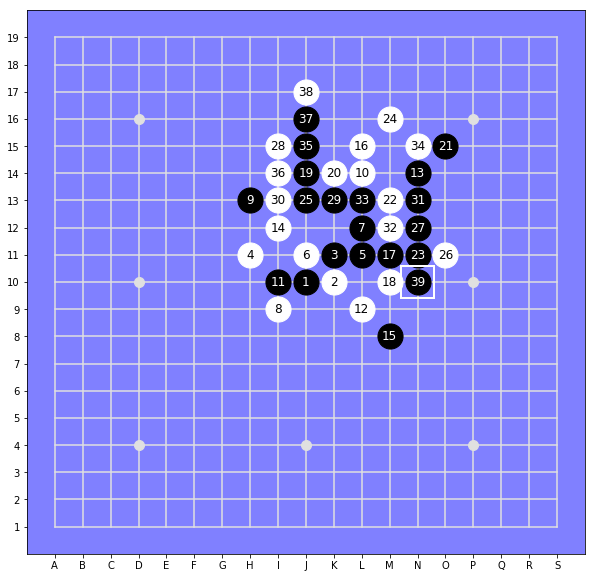

In [11]:
board = GomokuBoard(N=19, heuristics=Heuristics(kappa=3.0), stones=episodes[0], 
                    disp_width=10)
board.display()

---
# Value Function Fitting
Now we create a dataset for fitting the value function. The labels are:

$$
y_{i,t} = r(s_{i,t}, a_{i,t}) + \hat V_{\phi}^{\pi}(s_{i,t+2})
$$

Note the index $t+2$ in the value function. We're training by fitting to the next sample of the same player.

## Generating Samples 
```tf.keras``` can create ```tf.data``` datasets from generators. We use class ```A2C_SampleGeneratorFactory``` to create a fresh sample using the current policy.

In [12]:
from wgomoku import A2C_SampleGeneratorFactory
factory = A2C_SampleGeneratorFactory(19, value_model, gamma=.9, cut_off=None)

### Understandig the *shift*

The following depiction should help understand method ```_generator``` of class ```A2C_SampleGeneratorFactory```


S0, S1, S2, S3, S4, S5, S6, S7, S8   # sample positions

V2, V3, V4, V5, V6, V7, V8, +1, -1   # shifted to the left, padded with -1, 1 and multiplied by gamma
                                     

V0, V1, V2, V3, V4, V5, V6, V7, V8

You can easily convince yourself that the target definitions for the value update and the policy update can be taken from this setup.

### Episodes
Quick-check: Episodes end with value -1

In [13]:
episodes = sp.create_episodes(3, m2b='padded')

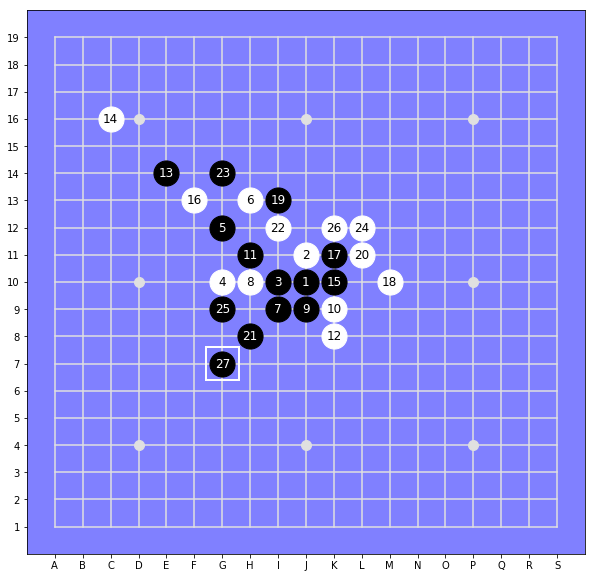

In [14]:
stones = [gt.m2b(move, 19)
    for move in np.array(episodes[0])-[1,1]]

board = GomokuBoard(N=19, heuristics=Heuristics(kappa=3.0), stones=stones, 
                    disp_width=10)
board.display()

In [15]:
generator = factory.create_generator(episodes, kind='values')
iterator = generator()

### Quick check
Run this cell until the value is -1 and then compare to the image above.

In [42]:
s, v = next(iterator)
display_sample(s)
print(v)

[[ 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  1  0  1 -1  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0 -1  0  1  0  1  1  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0 -1  0  1 -1  1  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  1  1 -1 -1 -1  0  1  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0 -1  0 -1 -1  1  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0 -1  0  0  1  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0

---
# The Serious Curriculum

In [49]:
GAMMA = 0.9
N_EPOCHS = 5
N_EPISODES = 4
BATCH_SIZE = 256
VALUE_MODEL_DIR = "./models/ValueNet_3.0/"
POLICY_MODEL_DIR = "./models/PolicyNet_1.0/"

---
#### Load the models from their lates checkpoints

In [44]:
latest_value_model = tf.train.latest_checkpoint(VALUE_MODEL_DIR)
print(latest_value_model)
value_model = ValueModel(19, 10, 3, 32, 'relu')
value_model.load_weights(latest_value_model)

# The Critic is getting ready
factory = A2C_SampleGeneratorFactory(19, value_model, gamma=GAMMA, cut_off=None)

./models/ValueNet_3.0/cp-0001.ckpt


In [45]:
latest_policy_model = tf.train.latest_checkpoint(POLICY_MODEL_DIR)
print(latest_policy_model)
policy_model = PolicyModel(board_size=19, n_blocks=10, 
                    n_layers=3, n_filters=32, 
                    activation='relu')
policy_model.load_weights(latest_policy_model)

# So is the Actor
sp = SelfPlay(policy=policy_model, board_size=19)

./models/PolicyNet_1.0/cp-0006.ckpt


In [46]:
sdh = SampleDataHelper(N, representation='NxNx1B', cut_off=12)

In [47]:
def new_value_dataset(n_episodes, n_epochs, batch_size):
    """
    Create a dataset of (state, target) pairs
    target = V(s_t+2)
    """
    episodes = sp.create_episodes(n_episodes, m2b='padded')
    generator = factory.create_generator(episodes, kind='values')
    inputs = tf.data.Dataset.from_generator(
        generator, output_types=(tf.int32, tf.float32))

    inputs = inputs.shuffle(100).repeat(n_epochs).batch(batch_size)
    return inputs, episodes


def new_policy_dataset(episodes, n_epochs, batch_size):
    """
    create a data set of (state, action, advantage) triples, given existing
    episodes
    advantage = V(s_t+2) - V(s_t)
    """
    generator = factory.create_generator(episodes, kind='advantages')
    inputs = tf.data.Dataset.from_generator(
        generator, output_types=(tf.int32, tf.int32, tf.float32))

    inputs = inputs.shuffle(100).repeat(n_epochs).batch(batch_size)
    return inputs

---
#### 1) Sample a little batch (N episodes x 8 symmetries)

In [50]:
value_inputs, episodes = new_value_dataset(
    n_episodes=N_EPISODES,
    n_epochs=N_EPOCHS, 
    batch_size=BATCH_SIZE)

---
#### 2) Train for some epochs

In [51]:
optimizer = tf.keras.optimizers.SGD(learning_rate=5e-3)
value_model.compile(optimizer=optimizer, loss='mean_squared_error')

value_model.fit(value_inputs)

14/14 [==============================] - 14s 986ms/step - loss: 0.1059


---
#### 3) Examine the value network quality

After a while you may observe more and more of the alternating pattern sneaking in from the end of the episodes. That's a sign that the *Critic* is getting ready.

In [52]:
samples = sdh.traj_to_samples(episodes[0], -1, GAMMA)
print(np.shape(samples[0]))
values = value_model.call(samples[0])
values[-10:]

(22, 21, 21, 2)


<tf.Tensor: id=268617, shape=(10, 1), dtype=float32, numpy=
array([[ 0.20642224],
       [ 0.09065987],
       [ 0.21119347],
       [ 0.05917617],
       [ 0.26260635],
       [ 0.00617435],
       [ 0.2332395 ],
       [ 0.12692015],
       [ 0.25060555],
       [-0.16979004]], dtype=float32)>

---
#### 4) Prepare the dataset for policy training

$$
\hat{A}^\pi(s_i, a_i) = r(s_i, a_i) + \gamma\hat{V}_\phi^\pi(s_{i+2}) - \hat{V}_\phi^\pi(s_i)
$$

In [53]:
policy_inputs = new_policy_dataset(
    episodes = episodes,
    n_epochs=N_EPOCHS, 
    batch_size=BATCH_SIZE)

---
#### Intermezzo: What's in the dataset?

In [54]:
generator = factory.create_generator(episodes, kind='advantages')

In [55]:
batch=next(iter(generator()))

Keras accepts a third column in the dataset that represents the sample weights. This is a perfect place to position our *Critic*'s advice, i.e. the advantages.

In [56]:
np.shape(batch[0]), np.divmod(batch[1], 19), batch[2]

((21, 21, 2), (9, 10), 0.0009797848761081696)

---
#### 5) Train the policy network

In [57]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
policy_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2), loss=loss)
policy_model.fit(policy_inputs)

14/14 [==============================] - 18s 1s/step - loss: -0.0569


Note that the *loss* function can go below zero due to the potentially negative weights.

---
# Closing the loop

In [66]:
N_EPOCHS = 10
N_EPISODES = 16
BATCH_SIZE = 256
NUM_CYCLES = 5

In [67]:
for n in range(NUM_CYCLES):

    print("Cycle %s" % n)
    # Sample
    value_inputs, episodes = new_value_dataset(
        n_episodes=N_EPISODES,
        n_epochs=N_EPOCHS, 
        batch_size=BATCH_SIZE)
    
    # Fit value function
    value_model.fit(value_inputs)
    
    # Get policy data
    policy_inputs = new_policy_dataset(
        episodes = episodes,
        n_epochs=N_EPOCHS, 
        batch_size=BATCH_SIZE)
    
    # Fit policy function
    policy_model.fit(policy_inputs)
    

Cycle 0
162/162 [==============================] - 59s 366ms/step - loss: 0.0025
Cycle 1
162/162 [==============================] - 60s 369ms/step - loss: 0.0012
Cycle 2
134/134 [==============================] - 51s 379ms/step - loss: -0.0247
Cycle 3
153/153 [==============================] - 57s 372ms/step - loss: -0.0074
Cycle 4
123/123 [==============================] - 47s 383ms/step - loss: 0.0469


In [68]:
game, traj, terminated = sp.create_episode(limit=80, n_choices=10, 
                                           greedy_bias=300, m2b='board')

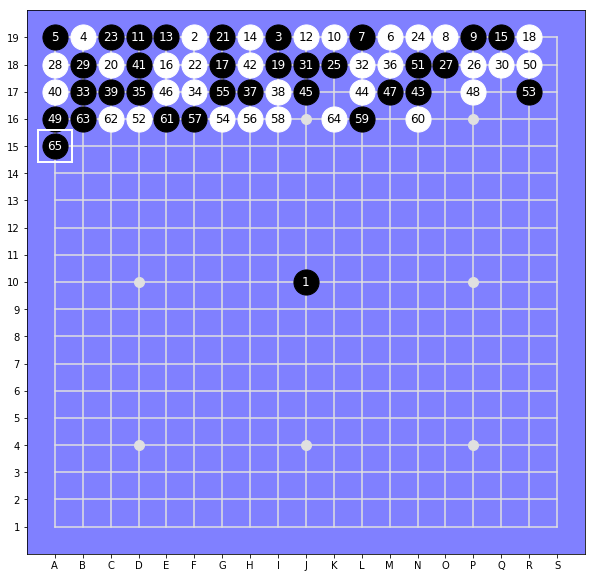

In [69]:
board = GomokuBoard(N=19, heuristics=Heuristics(kappa=3.0), stones=traj, 
                    disp_width=10)
board.display()